In [74]:
import tensorflow as tf
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import sys
import json
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.models import Model
from keras.applications.vgg16 import VGG16

# seq
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import pandas as pd
from typing import List

In [75]:
import datetime
import time

data_path: str = "../datasets/currency/price_dollar_rl.json"


def read_data(path: str) -> pd.DataFrame:
    with open(path, "r") as f:
        data = json.loads(f.read())
    data = data["data"]
    dataset = []
    # reverse data
    data = data[::-1]
    le = len(data)
    for i in range(le - 1):
        dataset.append(
            [
                int(data[i][0].replace(",", "", data[i][0].count(","))),
                int(data[i][1].replace(",", "", data[i][1].count(","))),
                int(data[i][2].replace(",", "", data[i][2].count(","))),
                int(data[i][3].replace(",", "", data[i][3].count(","))),
                (
                    1
                    - int(data[i][3].replace(",", "", data[i][3].count(",")))
                    / int(data[i + 1][3].replace(",", "", data[i + 1][3].count(",")))
                    if i < le - 1
                    else 0
                ),
                (
                    1
                    - int(data[i][1].replace(",", "", data[i][2].count(",")))
                    / int(data[i][2].replace(",", "", data[i][2].count(",")))
                    if i > 0
                    else 0
                ),
                datetime.datetime.strptime(data[i][6], "%Y/%m/%d"),
            ]
        )
    return pd.DataFrame(
        dataset,
        columns=["open", "low", "high", "close", "change", "change_in_day", "date"],
    )

In [76]:
df = read_data(data_path)
#
# imoprt scalar
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df[["change_in_day", "change", "open", "low", "high", "close"]])
df[["change_in_day", "change", "open", "low", "high", "close"]] = scaler.transform(
    df[["change_in_day", "change", "open", "low", "high", "close"]]
)

In [77]:
def create_dataset(
    data: pd.DataFrame,
    previous_days: int = 60,
    features: List[str] = ["change"],
    data_features: List[str] = "__all__",
    column_names: str = "day_%d",
) -> pd.DataFrame:
    if previous_days > len(data):
        raise ValueError("previous_days must be less than the length of the data")

    if data_features == "__all__":
        data_features = data.columns.tolist()

    output = []
    for j in range(previous_days, len(data)):
        selected_features = data.iloc[j - previous_days : j, :][
            features
        ].values.flatten()
        # additional_data = data.iloc[j - 1][data_features].values.tolist()
        output.append(list(selected_features))

    column_names_list = [
        column_names % (i + 1) for i in range(previous_days - 1)
    ] + data_features
    return pd.DataFrame(output, columns=column_names_list)

In [78]:
previous_days = 60

ds = create_dataset(
    df,
    previous_days=previous_days,
    features="change",
    data_features=["change"],
    column_names="day_%d",
)

In [79]:
df

,open,low,high,close,change,change_in_day,date
0,0.000654,0.001586,0.000645,0.000652,0.577285,0.017648,2011-11-26
1,0.000168,0.001101,0.000166,0.000168,0.597145,0.017648,2011-11-27
2,0.000000,0.000933,0.000000,0.000000,0.613647,0.017648,2011-11-28
3,0.000093,0.001026,0.000092,0.000093,0.619439,0.017648,2011-11-29
4,0.000280,0.001213,0.000277,0.000279,0.625083,0.017648,2011-11-30
...,...,...,...,...,...,...,...
3718,0.915277,0.915197,0.907312,0.914197,0.607955,0.021937,2023-12-09
3719,0.917425,0.916690,0.907054,0.914309,0.610200,0.019912,2023-12-10
3720,0.917163,0.916690,0.907460,0.915761,0.603953,0.020385,2023-12-11
3721,0.918974,0.916317,0.907884,0.913489,0.607173,0.021310,2023-12-12


In [80]:
ds

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_51,day_52,day_53,day_54,day_55,day_56,day_57,day_58,day_59,change
0,0.577285,0.597145,0.613647,0.619439,0.625083,0.603136,0.612385,0.596139,0.596052,0.607767,...,0.558943,0.671647,0.632911,0.616104,0.632388,0.624012,0.574595,0.636268,0.619888,0.615807
1,0.597145,0.613647,0.619439,0.625083,0.603136,0.612385,0.596139,0.596052,0.607767,0.617084,...,0.671647,0.632911,0.616104,0.632388,0.624012,0.574595,0.636268,0.619888,0.615807,0.591523
2,0.613647,0.619439,0.625083,0.603136,0.612385,0.596139,0.596052,0.607767,0.617084,0.619328,...,0.632911,0.616104,0.632388,0.624012,0.574595,0.636268,0.619888,0.615807,0.591523,0.591354
3,0.619439,0.625083,0.603136,0.612385,0.596139,0.596052,0.607767,0.617084,0.619328,0.623787,...,0.616104,0.632388,0.624012,0.574595,0.636268,0.619888,0.615807,0.591523,0.591354,0.624012
4,0.625083,0.603136,0.612385,0.596139,0.596052,0.607767,0.617084,0.619328,0.623787,0.600872,...,0.632388,0.624012,0.574595,0.636268,0.619888,0.615807,0.591523,0.591354,0.624012,0.611818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3658,0.610688,0.607767,0.606624,0.617083,0.607767,0.623617,0.651681,0.616291,0.588461,0.605408,...,0.617720,0.608204,0.608235,0.605738,0.608766,0.609357,0.601414,0.610329,0.607455,0.608423
3659,0.607767,0.606624,0.617083,0.607767,0.623617,0.651681,0.616291,0.588461,0.605408,0.599977,...,0.608204,0.608235,0.605738,0.608766,0.609357,0.601414,0.610329,0.607455,0.608423,0.607955
3660,0.606624,0.617083,0.607767,0.623617,0.651681,0.616291,0.588461,0.605408,0.599977,0.607767,...,0.608235,0.605738,0.608766,0.609357,0.601414,0.610329,0.607455,0.608423,0.607955,0.610200
3661,0.617083,0.607767,0.623617,0.651681,0.616291,0.588461,0.605408,0.599977,0.607767,0.596228,...,0.605738,0.608766,0.609357,0.601414,0.610329,0.607455,0.608423,0.607955,0.610200,0.603953


In [81]:
from sklearn.preprocessing import StandardScaler

X = ds.iloc[:, :-1].values
y = ds.iloc[:, -1].values

In [82]:
X_train, X_test, y_train, y_test = (
    X[: len(X) - previous_days],
    X[len(X) - previous_days :],
    y[: len(X) - previous_days],
    y[len(X) - previous_days :],
)

In [83]:
from sklearn.linear_model import LinearRegression, ElasticNet

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

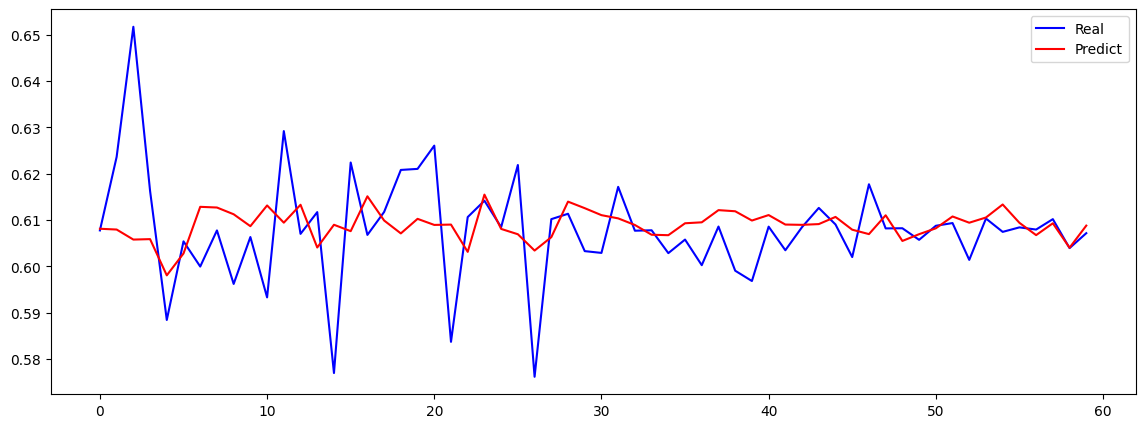

In [84]:
predict = model.predict(X_test)
plt.figure(figsize=(14, 5))
plt.plot(y_test, label="Real", color="blue")
plt.plot(predict, label="Predict", color="red")
plt.legend()

In [85]:
from datetime import datetime

In [86]:
def predict_tomorow(
    data: pd.DataFrame, model: LinearRegression, previous_days: int
) -> float:
    return model.predict([data])[0]


def predict(
    day: datetime,
    data: pd.DataFrame,
    model: LinearRegression,
    previous_days: int,
    last_day: datetime,
) -> List[float]:
    last_data = data.iloc[-previous_days + 1 :]["change"].values
    days = day - last_day
    days = days.days
    for i in range(days):
        pred = model.predict([last_data])[0]
        last_data = np.append(last_data[1:], pred)
    return last_data[-1]

Mean Absolute Error: 0.014408206209992907
Mean Squared Error: 0.0008218920994551417
R-squared: -0.13735841104559143


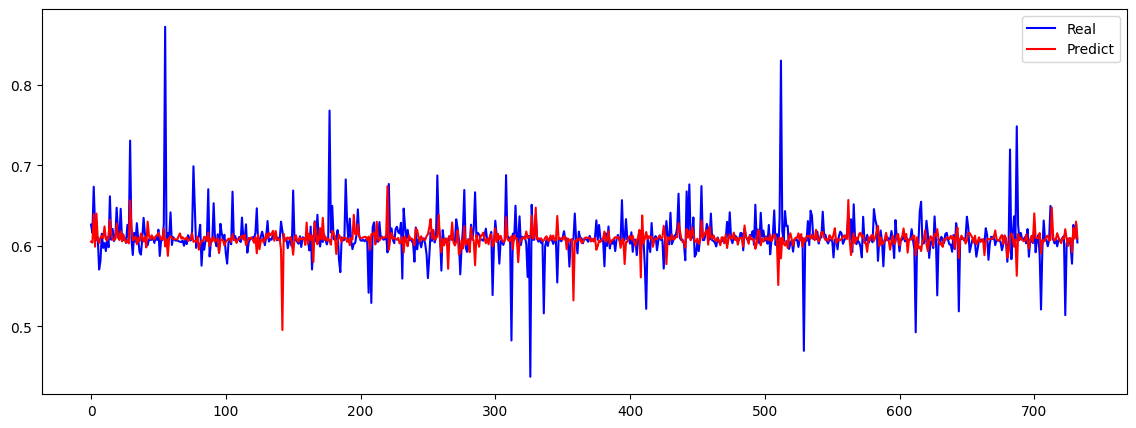

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

predict = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
r2 = r2_score(y_test, predict)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(y_test, label="Real", color="blue")
plt.plot(predict, label="Predict", color="red")
plt.legend()
plt.show()

In [88]:
df.iloc[-1]["date"]

Timestamp('2023-12-13 00:00:00')

In [89]:
df.iloc[-1]["date"]

Timestamp('2023-12-13 00:00:00')

In [90]:
print(X_test)

[[0.60865184 0.61173748 0.60334375 ... 0.61883083 0.61412438 0.6195451 ]
 [0.61601707 0.60030748 0.60693805 ... 0.62547178 0.61218107 0.62089814]
 [0.6512739  0.60776737 0.58034309 ... 0.53778672 0.51956669 0.66960416]
 ...
 [0.59973189 0.61238225 0.60776737 ... 0.57701446 0.62240904 0.60680105]
 [0.60702426 0.5866821  0.60776737 ... 0.57980275 0.53859127 0.62297623]
 [0.60962284 0.61236449 0.62221002 ... 0.58412321 0.60776737 0.60184877]]
